### Todo: Train and Evaluate Model

In [2]:
import pandas as pd
from prep_train_pipeline import prep_train_pipeline
from helper_roberta import tokenize, create_model
from transformers import RobertaTokenizerFast, TFRobertaModel
import tensorflow as tf

In [4]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [5]:
# check gpu
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# read csv
df_512_token = pd.read_csv("text_512_tokens.csv")
df_512_token = df_512_token.drop(columns=["Unnamed: 0"])
df_512_token.head()

,text,target
0,introduction hi im a scientist at nasa and im ...,1.0
1,la mona lisa was created by one of the best dr...,0.0
2,have you ever heard of the seagoing cowboys pr...,0.0
3,online schooling has become increasingly popul...,1.0
4,many people and other scientists believe that ...,0.0


Creating Train, Test split...
Done! check for balance ...


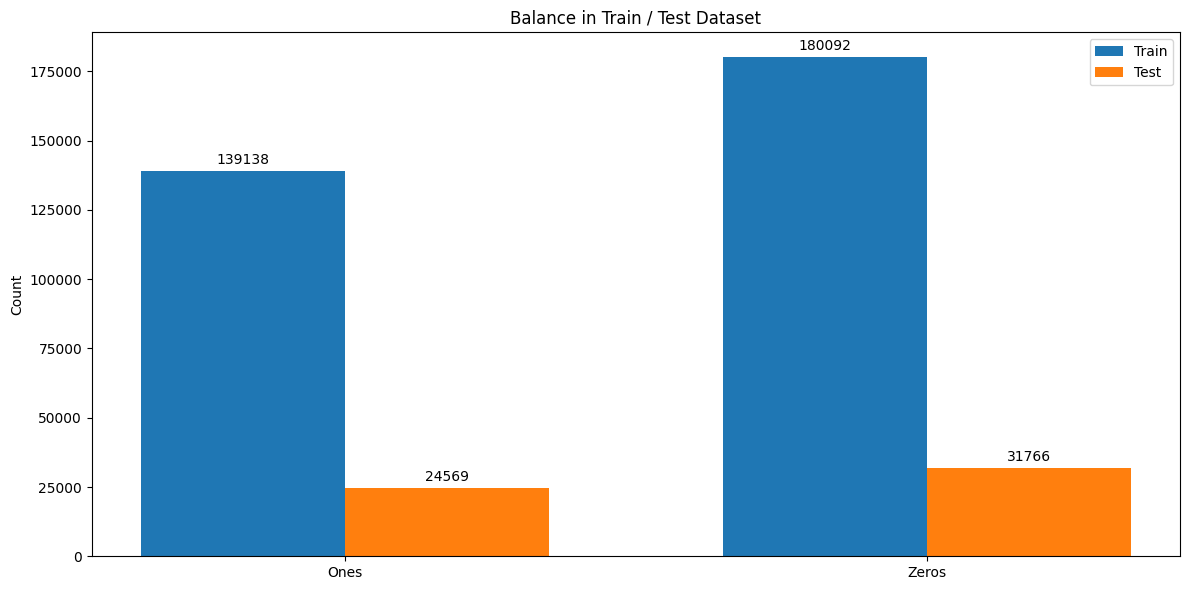

Looks unbalanced! Balancing Train Set...


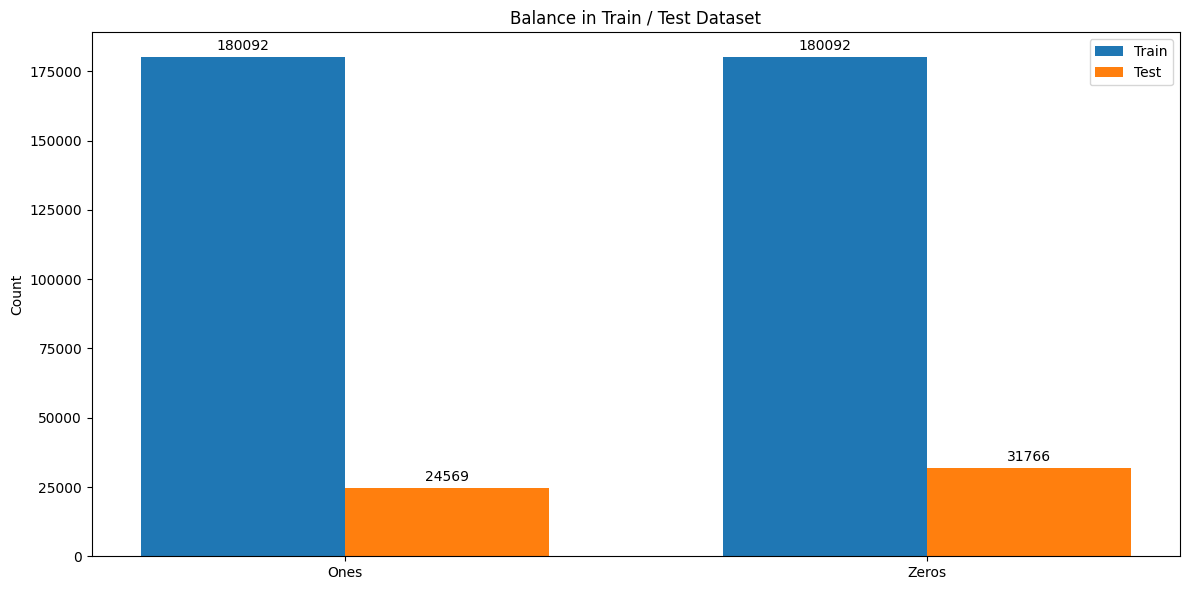

Done!


In [7]:
# preprocess for training pipeline
X_train, X_test, y_train, y_test = prep_train_pipeline(df=df_512_token)

### looks good, we should keep in mind that it could lead to overfitting (because copies), so we'll build in regulizations later

In [ ]:
# roberta tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# turn features in input_ids, attention_masks, less training time
train_input_ids, train_attention_masks = tokenize(data=X_train, tokenizer=tokenizer)
test_input_ids, test_attention_masks = tokenize(data=X_test, tokenizer=tokenizer)

In [ ]:
# create the model and show the summary (we dont freeze the backbone, so directly finetune it)

roberta_model = TFRobertaModel.from_pretrained("roberta-base")

model = create_model(roberta_model=roberta_model)
model.summary()

In [ ]:
del df_512_token, X_train, X_test, tokenizer, roberta_model

In [ ]:
# define some callbacks

checkpoint_path = "./512_roberta_model/"
logs = "./logs/"

# save best model (monitor = val_loss)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=0, save_best_only=True
)

# stop training after 6 epochs no improvement, restore best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=6, verbose=0, restore_best_weights=True
)

# after 3 epochs no improvement, reduce lr (factor = 0.1, so 1e-4 -> 1e-5)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_lr=1e-8)

# tensorboard callback for better visual evaluation
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs)

In [ ]:
callbacks = [model_checkpoint, early_stopping, reduce_lr_on_plateau, tensorboard]

# model ready for training
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=15,
    batch_size=8,
    callbacks=callbacks,
)